### Weather Image Classification

In [23]:
#import packages needed
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import copy, math, os, sys, torch
from collections import namedtuple
from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, recall_score
from torch import Tensor, nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.utils
from torchvision.models import vgg
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

In [24]:
#connect to gpu
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
#set image classes
classes = ('Cloudy', 'Rain', 'Shine', 'Sunrise')

In [21]:
#get a sample image from each folder
cloudy_img = Image.open('WeatherImages/cloudy/cloudy15.jpg')
rain_img = Image.open('WeatherImages/rain/rain18.jpg')
shine_img = Image.open('WeatherImages/shine/shine15.jpg')
sunrise_img = Image.open('WeatherImages/sunrise/sunrise42.jpg')
example_imgs = [cloudy_img, rain_img, shine_img, sunrise_img]

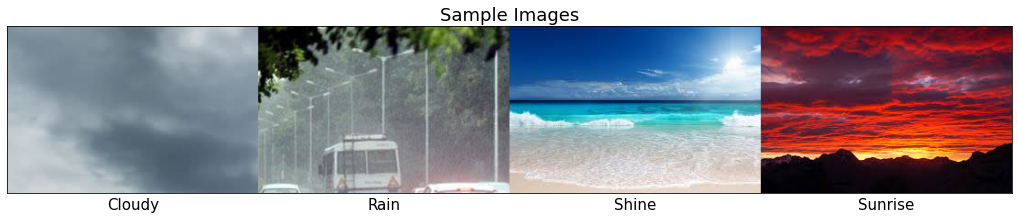

In [25]:
#show sample images
w, h = example_imgs[2].size
grid = Image.new('RGBA', size=(4*w, h))
grid_w, grid_h = grid.size
ls = grid_w/4   # label spacing

for i, img in enumerate(example_imgs):
    grid.paste(img, box=(i%4*w, i//4*h))

plt.figure(figsize=(18,10))
plt.title('Sample Images', fontsize=18)
plt.imshow(grid)
plt.xticks([ls-ls/2, ls*2-ls/2, ls*3-ls/2, ls*4-ls/2], classes, fontsize=15)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.yticks([])
plt.show()

In [27]:
#get the number of images per class
num_cloudy = len(os.listdir('WeatherImages/cloudy/'))
num_rain = len(os.listdir('WeatherImages/rain/'))
num_shine = len(os.listdir('WeatherImages/shine/'))
num_sunrise = len(os.listdir('WeatherImages/sunrise/'))

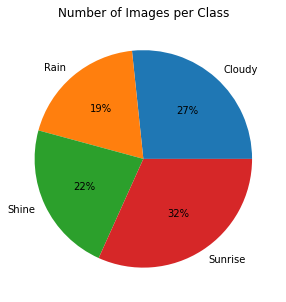

In [31]:
plt.figure(figsize=(5,5))
plt.pie([num_cloudy, num_rain, num_shine, num_sunrise], labels = classes, autopct='%.0f%%')
plt.title("Number of Images per Class")
plt.show()

In [33]:
#set transformation
transformations = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [34]:
#extract dataset using transformation
original_dataset = datasets.ImageFolder('WeatherImages/', transform = transformations)

In [35]:
#set size of test and train dataset
og_trn_size = int(0.8 * len(original_dataset))
og_tst_size = len(original_dataset) - og_trn_size 

In [36]:
#split dataset into train and test data
train_ds, test_ds = torch.utils.data.random_split(original_dataset, [og_trn_size, og_tst_size])

In [38]:
#get size of each dataset
print("No. of Images in Train Set:", len(train_ds))
print("No. of Images in Test Set:", len(test_ds))
print("Total:", len(train_ds) + len(test_ds))

No. of Images in Train Set: 900
No. of Images in Test Set: 225
Total: 1125


In [39]:
#set batch size
bs = 64

In [40]:
#create data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

#### Building a Neural Net Model - Fully Connected with 1 hidden layer

In [41]:
#create a fully connected neural network with 1 hidden layer
class SimpleNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(64*64*3, 100) # Fully connected layer with 100 hidden neurons
        self.fc2 = nn.Linear(100, num_classes) # Fully connected layer with num_classes outputs
 
    def forward(self, x):
        x = x.view(-1, 64*64*3) # reshape the input tensor
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [43]:
#create an instance of the neutal network
model = SimpleNet()

In [44]:
#loss function & optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
# train the model
num_epochs = 20
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

In [46]:
#training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    
    # set model to train mode
    model.train()
    # iterate over the training data
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        outputs = model(inputs)
        #compute the loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # increment the running loss and accuracy
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).sum().item() 
        
    # calculate the average training loss and accuracy
    train_loss /= len(train_dl)
    train_loss_history.append(train_loss)
    train_acc /= len(train_dl.dataset)
    train_acc_history.append(train_acc) 
    
    # set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).sum().item() 
            
    # calculate the average validation loss and accuracy
    val_loss /= len(test_dl)
    val_loss_history.append(val_loss)
    val_acc /= len(test_dl.dataset)
    val_acc_history.append(val_acc)
 
    print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

Epoch 1/20, train loss: 1.4731, train acc: 0.4811, val loss: 1.3155, val acc: 0.4889
Epoch 2/20, train loss: 0.9085, train acc: 0.6378, val loss: 0.7395, val acc: 0.6933
Epoch 3/20, train loss: 0.7174, train acc: 0.7222, val loss: 0.5856, val acc: 0.7778
Epoch 4/20, train loss: 0.6361, train acc: 0.7622, val loss: 0.6656, val acc: 0.7467
Epoch 5/20, train loss: 0.5705, train acc: 0.7822, val loss: 0.5326, val acc: 0.8133
Epoch 6/20, train loss: 0.5578, train acc: 0.8144, val loss: 0.4786, val acc: 0.7956
Epoch 7/20, train loss: 0.7211, train acc: 0.7900, val loss: 0.4865, val acc: 0.8089
Epoch 8/20, train loss: 0.6131, train acc: 0.7656, val loss: 0.5554, val acc: 0.7911
Epoch 9/20, train loss: 0.5933, train acc: 0.7911, val loss: 0.4740, val acc: 0.8000
Epoch 10/20, train loss: 0.5351, train acc: 0.7933, val loss: 0.4780, val acc: 0.8133
Epoch 11/20, train loss: 0.5542, train acc: 0.7922, val loss: 0.4404, val acc: 0.8044
Epoch 12/20, train loss: 0.4612, train acc: 0.8289, val loss: 0

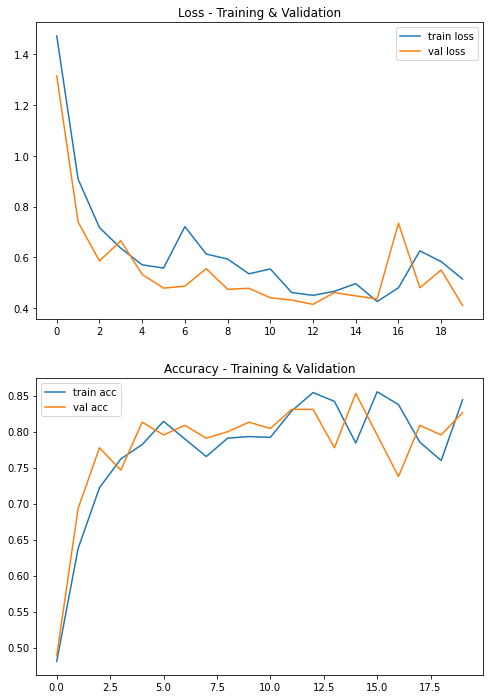

In [65]:
# Plot the training and validation loss
plt.figure(figsize = (8,12))
plt.subplot(2,1,1)
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')
plt.legend()
plt.xticks(np.arange(0,20,step=2))
plt.xlabel("Epoch No.")
plt.ylabel("Loss")
plt.title("Loss - Training & Validation")
#plt.show()
 
# Plot the training and validation accuracy
plt.subplot(2,1,2)
plt.plot(train_acc_history, label='train acc')
plt.plot(val_acc_history, label='val acc')
plt.legend()
plt.xticks(np.arange(0,20,step=2))
plt.ylabel("Accuracy")
plt.xlabel("Epoch No.")
plt.title("Accuracy - Training & Validation")
plt.show()

In [62]:
mean_val_acc = np.mean(val_acc_history)
print(f'Model accuracy: {mean_val_acc:.3f}')

Model accuracy: 0.761
